## Бизнес цели

1. Прогнозирование цен на акции Tesla на основе действий инсайдеров: Одна из ключевых бизнес-целей состоит в создании модели для прогнозирования динамики акций Tesla, используя данные о транзакциях инсайдеров. Поскольку инсайдеры обладают глубоким знанием внутреннего состояния компании, их действия могут предсказывать изменения в стоимости акций. На основе анализа паттернов и частоты инсайдерских покупок и продаж можно разработать предсказательную модель, которая поможет инвесторам и аналитикам принимать более обоснованные решения.
2. Анализ влияния транзакций инсайдеров на динамику цены акций Tesla для оценки краткосрочных и долгосрочных рисков: Цель – исследовать, как действия инсайдеров (особенно крупных акционеров и ключевых лиц) влияют на цену акций Tesla. Выявление корреляций между объёмом, типом и частотой инсайдерских сделок и изменениями цены акций позволит оценить риски и тенденции в динамике акций.

Цель технического проекта: Разработка модели машинного обучения для прогнозирования будущих продаж акций топ-менеджментом компании, а также анализ влияния транзакций инсайдеров на динамику цены акций Tesla для оценки краткосрочных и долгосрочных рисков.

In [228]:
from typing import Any
from math import ceil
import time

import pandas as pd
from pandas import DataFrame, Series
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from imblearn.over_sampling import SMOTE
import featuretools as ft
from featuretools.entityset.entityset import EntitySet
import matplotlib.pyplot as plt

df: DataFrame = pd.read_csv("static/csv/TSLA.csv")

Конвертация данных:

In [229]:
# Преобразование типов данных
df['Insider Trading'] = df['Insider Trading'].astype('category')                             
df['Relationship'] = df['Relationship'].astype('category')                                   
df['Transaction'] = df['Transaction'].astype('category')                                     
df['Cost'] = pd.to_numeric(df['Cost'], errors='coerce')                                      
df['Shares'] = pd.to_numeric(df['Shares'].str.replace(',', ''), errors='coerce')             
df['Value ($)'] = pd.to_numeric(df['Value ($)'].str.replace(',', ''), errors='coerce')       
df['Shares Total'] = pd.to_numeric(df['Shares Total'].str.replace(',', ''), errors='coerce')

print('Выборка данных:')
df.head(10)

Выборка данных:


Insider Trading                    Relationship        Date  \
0  Kirkhorn Zachary         Chief Financial Officer  2022-03-06   
1    Taneja Vaibhav        Chief Accounting Officer  2022-03-06   
2  Baglino Andrew D  SVP Powertrain and Energy Eng.  2022-03-06   
3    Taneja Vaibhav        Chief Accounting Officer  2022-03-05   
4  Baglino Andrew D  SVP Powertrain and Energy Eng.  2022-03-05   
5  Kirkhorn Zachary         Chief Financial Officer  2022-03-05   
6  Baglino Andrew D  SVP Powertrain and Energy Eng.  2022-02-27   
7  Baglino Andrew D  SVP Powertrain and Energy Eng.  2022-02-27   
8  Kirkhorn Zachary         Chief Financial Officer  2022-02-06   
9  Baglino Andrew D  SVP Powertrain and Energy Eng.  2022-01-27   

       Transaction    Cost  Shares  Value ($)  Shares Total       SEC Form 4  
0             Sale  196.72   10455    2056775        203073  Mar 07 07:58 PM  
1             Sale  195.79    2466     482718        100458  Mar 07 07:57 PM  
2             Sale  195.79    1298     254232         65547  Mar 07 08:01 PM  
3  Option Exercise    0.00    7138          0        102923  Mar 07 07:57 PM  
4  Option Exercise    0.00    2586          0         66845  Mar 07 08:01 PM  
5  Option Exercise    0.00   16867          0        213528  Mar 07 07:58 PM  
6  Option Exercise   20.91   10500     219555         74759  Mar 01 07:29 PM  
7             Sale  202.00   10500    2121000         64259  Mar 01 07:29 PM  
8             Sale  193.00    3750     723750        196661  Feb 08 06:14 PM  
9  Option Exercise   20.91   10500     219555         74759  Jan 31 07:34 PM

Проблема пропущенных данных:

Проверка на отсутствие значений, представленная ниже, показала, что DataFrame не имеет пустых значений признаков. Нет необходимости использовать методы заполнения пропущенных данных.

In [230]:
# Проверка пропущенных данных
def check_null_columns(dataframe: DataFrame) -> None:
    # Присутствуют ли пустые значения признаков
    print('Присутствуют ли пустые значения признаков в колонке:')
    print(dataframe.isnull().any(), '\n')

    # Количество пустых значений признаков
    print('Количество пустых значений признаков в колонке:')
    print(dataframe.isnull().sum(), '\n')

    # Процент пустых значений признаков
    print('Процент пустых значений признаков в колонке:')
    for column in dataframe.columns:
        null_rate: float = dataframe[column].isnull().sum() / len(dataframe) * 100
        if null_rate > 0:
            print(f"{column} процент пустых значений: {null_rate:.2f}%")
    print()
            

# Проверка пропущенных данных
check_null_columns(df)

Присутствуют ли пустые значения признаков в колонке:
Insider Trading    False
Relationship       False
Date               False
Transaction        False
Cost               False
Shares             False
Value ($)          False
Shares Total       False
SEC Form 4         False
dtype: bool 

Количество пустых значений признаков в колонке:
Insider Trading    0
Relationship       0
Date               0
Transaction        0
Cost               0
Shares             0
Value ($)          0
Shares Total       0
SEC Form 4         0
dtype: int64 

Процент пустых значений признаков в колонке:



Проблема зашумленности данных

Зашумленность – это наличие случайных ошибок или вариаций в данных, которые могут затруднить выявление истинных закономерностей.
В свою очередь выбросы - это значения, которые значительно отличаются от остальных наблюдений в наборе данных
Представленный ниже код помогает определить наличие выбросов в наборе данных и устранить их (при наличии), заменив значения ниже нижней границы (рассматриваемого минимума) на значения нижней границы, а значения выше верхней границы (рассматриваемого максимума) – на значения верхней границы.

Проверка наличия выбросов в колонках:
Колонка Cost:
	Есть выбросы: Нет
	Количество выбросов: 0
	Минимальное значение: 0.0
	Максимальное значение: 1171.04
	1-й квартиль (Q1): 50.5225
	3-й квартиль (Q3): 934.1075

Колонка Shares:
	Есть выбросы: Да
	Количество выбросов: 25
	Минимальное значение: 121
	Максимальное значение: 11920000
	1-й квартиль (Q1): 3500.0
	3-й квартиль (Q3): 301797.75

Колонка Value ($):
	Есть выбросы: Да
	Количество выбросов: 23
	Минимальное значение: 0
	Максимальное значение: 2278695421
	1-й квартиль (Q1): 271008.0
	3-й квартиль (Q3): 148713213.25

Колонка Shares Total:
	Есть выбросы: Да
	Количество выбросов: 21
	Минимальное значение: 49
	Максимальное значение: 455467432
	1-й квартиль (Q1): 25103.5
	3-й квартиль (Q3): 1507273.75



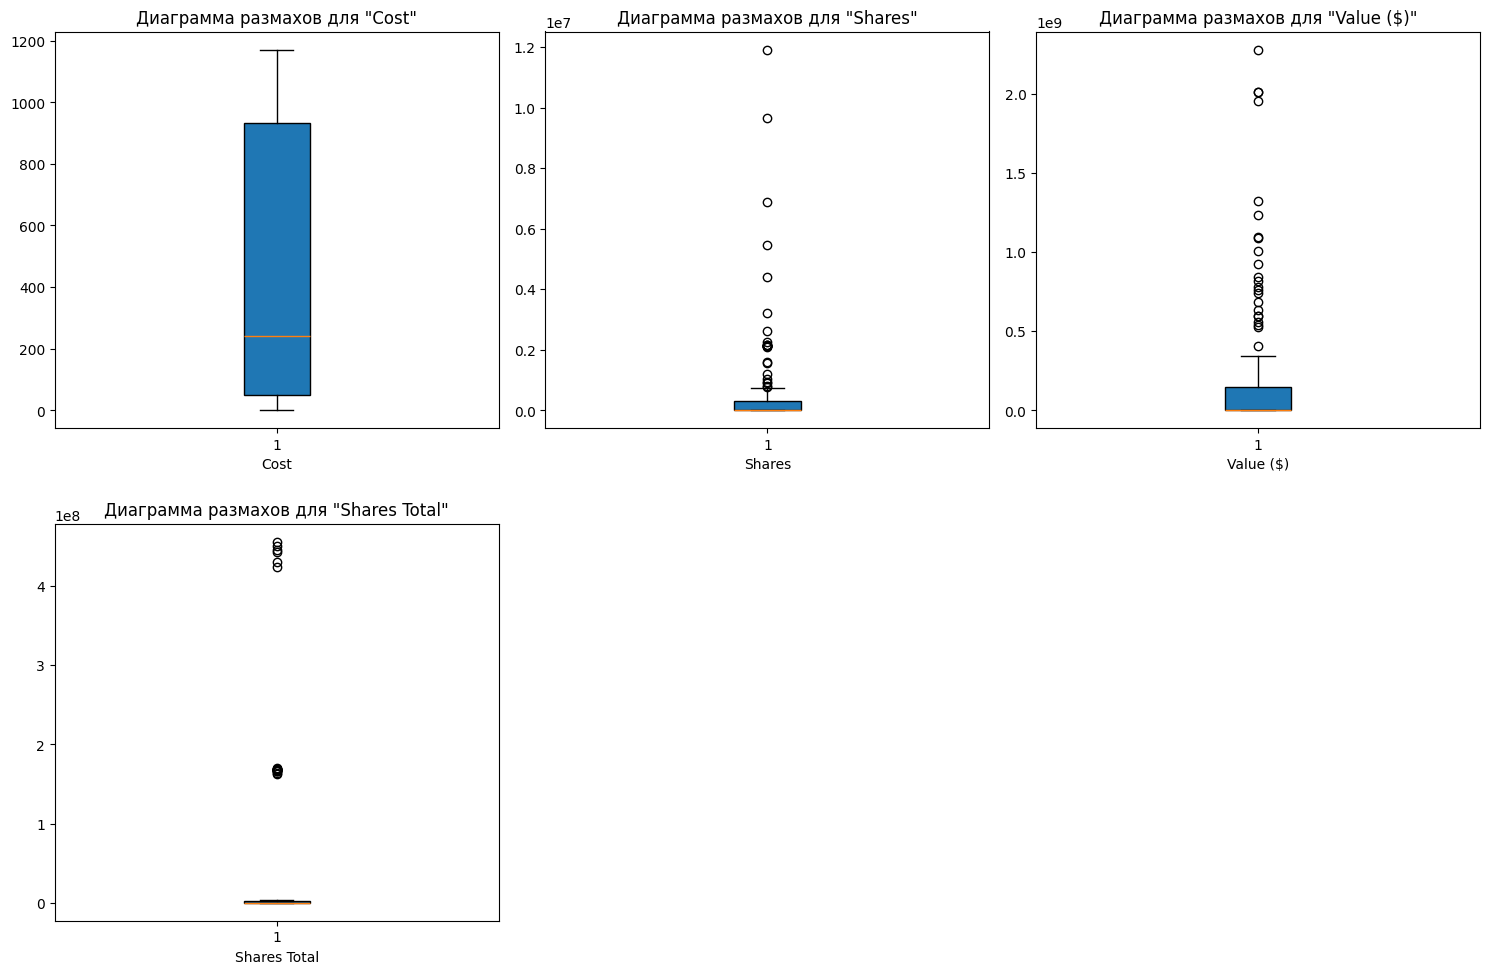

In [231]:
# Проверка выбросов в DataFrame
def check_outliers(dataframe: DataFrame, columns: list[str]) -> None:
    for column in columns:
        if not pd.api.types.is_numeric_dtype(dataframe[column]): # Проверяем, является ли колонка числовой
            continue
        
        Q1: float = dataframe[column].quantile(0.25) # 1-й квартиль (25%)
        Q3: float = dataframe[column].quantile(0.75) # 3-й квартиль (75%)
        IQR: float = Q3 - Q1 # Вычисляем межквартильный размах

        # Определяем границы для выбросов
        lower_bound: float = Q1 - 1.5 * IQR # Нижняя граница
        upper_bound: float = Q3 + 1.5 * IQR # Верхняя граница

        # Подсчитываем количество выбросов
        outliers: DataFrame = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
        outlier_count: int = outliers.shape[0]

        print(f"Колонка {column}:")
        print(f"\tЕсть выбросы: {'Да' if outlier_count > 0 else 'Нет'}")
        print(f"\tКоличество выбросов: {outlier_count}")
        print(f"\tМинимальное значение: {dataframe[column].min()}")
        print(f"\tМаксимальное значение: {dataframe[column].max()}")
        print(f"\t1-й квартиль (Q1): {Q1}")
        print(f"\t3-й квартиль (Q3): {Q3}\n")

# Визуализация выбросов
def visualize_outliers(dataframe: DataFrame, columns: list[str]) -> None:
    # Диаграммы размахов
    plt.figure(figsize=(15, 10))
    rows: int = ceil(len(columns) / 3)
    for index, column in enumerate(columns, 1):
        plt.subplot(rows, 3, index)
        plt.boxplot(dataframe[column], vert=True, patch_artist=True)
        plt.title(f"Диаграмма размахов для \"{column}\"")
        plt.xlabel(column)
            
    # Отображение графиков
    plt.tight_layout()
    plt.show()


# Числовые столбцы DataFrame
numeric_columns: list[str] = [
    'Cost',
    'Shares',
    'Value ($)',
    'Shares Total'
]

# Проверка наличия выбросов в колонках
print('Проверка наличия выбросов в колонках:')
check_outliers(df, numeric_columns)
visualize_outliers(df, numeric_columns)

Устраняем выбросы и проводим проверку на их устранение

Проверка наличия выбросов в колонках после их устранения:
Колонка Cost:
	Есть выбросы: Нет
	Количество выбросов: 0
	Минимальное значение: 0.0
	Максимальное значение: 1171.04
	1-й квартиль (Q1): 50.5225
	3-й квартиль (Q3): 934.1075

Колонка Shares:
	Есть выбросы: Нет
	Количество выбросов: 0
	Минимальное значение: 121.0
	Максимальное значение: 749244.375
	1-й квартиль (Q1): 3500.0
	3-й квартиль (Q3): 301797.75

Колонка Value ($):
	Есть выбросы: Нет
	Количество выбросов: 0
	Минимальное значение: 0.0
	Максимальное значение: 371376521.125
	1-й квартиль (Q1): 271008.0
	3-й квартиль (Q3): 148713213.25

Колонка Shares Total:
	Есть выбросы: Нет
	Количество выбросов: 0
	Минимальное значение: 49.0
	Максимальное значение: 3730529.125
	1-й квартиль (Q1): 25103.5
	3-й квартиль (Q3): 1507273.75



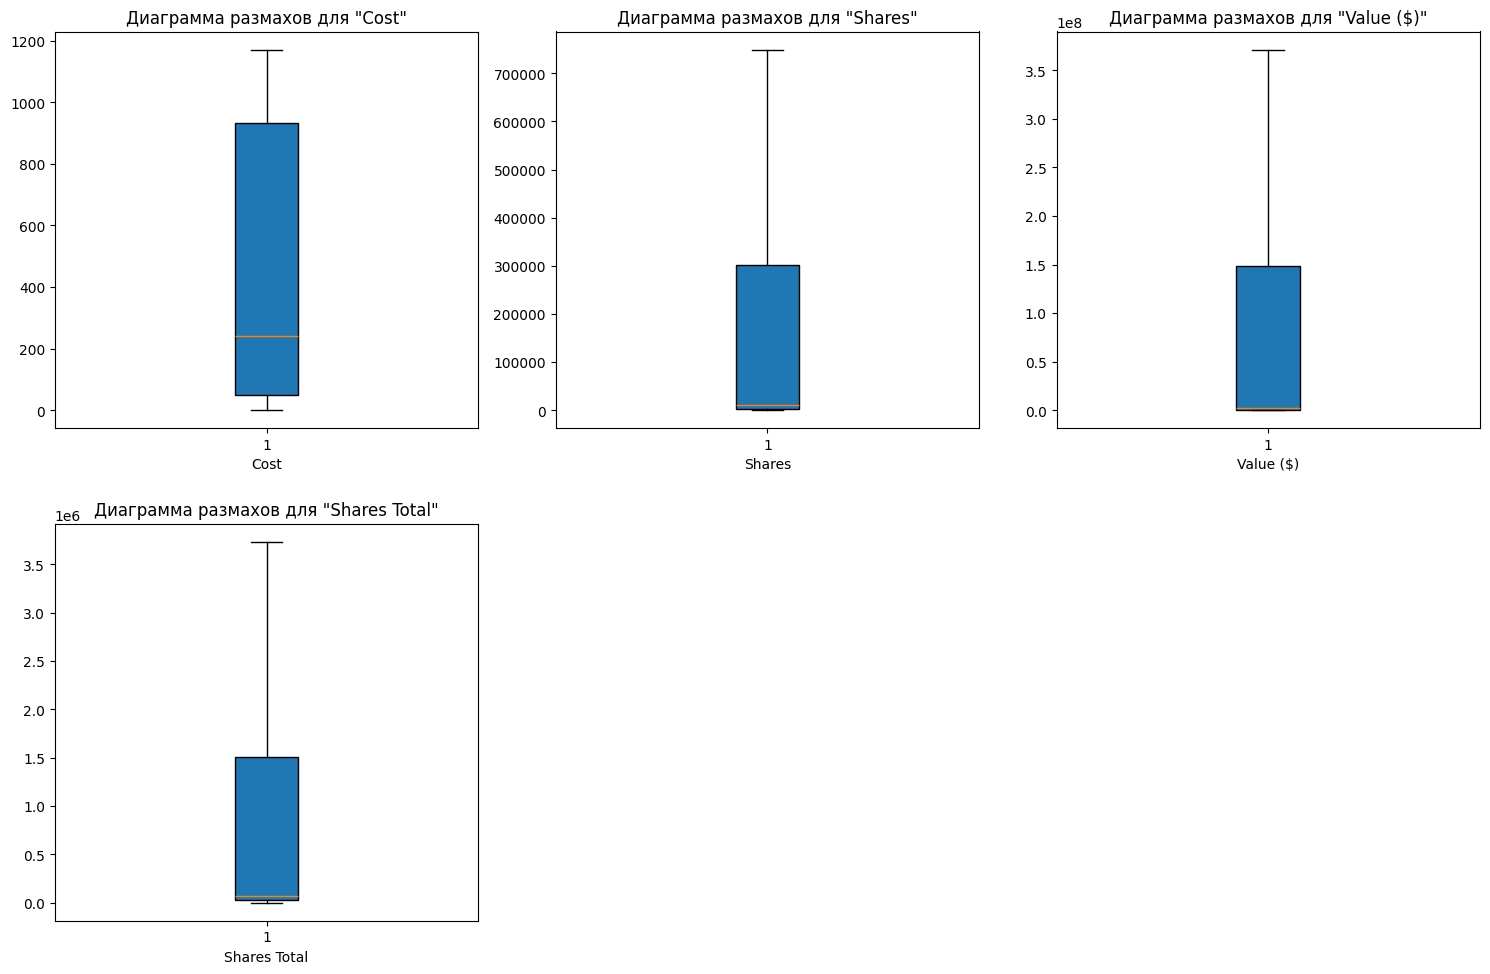

In [232]:
# Устранить выборсы в DataFrame
def remove_outliers(dataframe: DataFrame, columns: list[str]) -> DataFrame:
    for column in columns:
        if not pd.api.types.is_numeric_dtype(dataframe[column]): # Проверяем, является ли колонка числовой
            continue
        
        Q1: float = dataframe[column].quantile(0.25) # 1-й квартиль (25%)
        Q3: float = dataframe[column].quantile(0.75) # 3-й квартиль (75%)
        IQR: float = Q3 - Q1 # Вычисляем межквартильный размах

        # Определяем границы для выбросов
        lower_bound: float = Q1 - 1.5 * IQR # Нижняя граница
        upper_bound: float = Q3 + 1.5 * IQR # Верхняя граница

        # Устраняем выбросы:
        # Заменяем значения ниже нижней границы на нижнюю границу
        # А значения выше верхней границы – на верхнюю
        dataframe[column] = dataframe[column].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
    
    return dataframe


# Устраняем выборсы
df: DataFrame = remove_outliers(df, numeric_columns)

# Проверка наличия выбросов в колонках
print('Проверка наличия выбросов в колонках после их устранения:')
check_outliers(df, numeric_columns)
visualize_outliers(df, numeric_columns)

Разбиение набора данных на выборки:

Обучающая выборка (60-80%). Обучение модели (подбор коэффициентов некоторой математической функции для аппроксимации).
Контрольная выборка (10-20%). Выбор метода обучения, настройка гиперпараметров.
Тестовая выборка (10-20% или 20-30%). Оценка качества модели перед передачей заказчику.

Данные должны быть сбалансированными, чтобы достичь этого воспользуемся методами аугментации данных. В данном случае воспользуемся методом oversampling.

In [233]:
# Функция для создания выборок
def split_stratified_into_train_val_test(
    df_input,
    stratify_colname="y",
    frac_train=0.6,
    frac_val=0.15,
    frac_test=0.25,
    random_state=None,
) -> tuple[Any, Any, Any]:

    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError(
            "fractions %f, %f, %f do not add up to 1.0"
            % (frac_train, frac_val, frac_test)
        )

    if stratify_colname not in df_input.columns:
        raise ValueError("%s is not a column in the dataframe" % (stratify_colname))

    X: DataFrame = df_input
    y: DataFrame = df_input[
        [stratify_colname]
    ]

    df_train, df_temp, y_train, y_temp = train_test_split(
        X, y, 
        stratify=y, 
        test_size=(1.0 - frac_train), 
        random_state=random_state
    )

    relative_frac_test: float = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(
        df_temp,
        y_temp,
        stratify=y_temp,
        test_size=relative_frac_test,
        random_state=random_state,
    )

    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)

    return df_train, df_val, df_test

Распределение количества наблюдений по меткам (классам):
Cost
0.00       18
6.24       10
62.72       8
20.91       7
52.38       4
           ..
1098.24     1
1072.22     1
1019.03     1
1048.46     1
1068.09     1
Name: count, Length: 101, dtype: int64 

Статистическое описание целевого признака:
count     156.000000
mean      478.785641
std       448.922903
min         0.000000
25%        50.522500
50%       240.225000
75%       934.107500
max      1171.040000
Name: Cost, dtype: float64 

Распределение количества наблюдений по меткам (классам):
Cost_category
medium    78
low       39
high      39
Name: count, dtype: int64 

Проверка сбалансированности выборок:
Обучающая выборка:  (93, 184)
Распределение выборки данных по классам в колонке "Cost_category":
 Cost_category
medium    47
low       23
high      23
Name: count, dtype: int64
Процент объектов класса "medium": 50.54%
Процент объектов класса "low": 24.73%
Процент объектов класса "high": 24.73%

Контрольная выборка:  (31, 184)


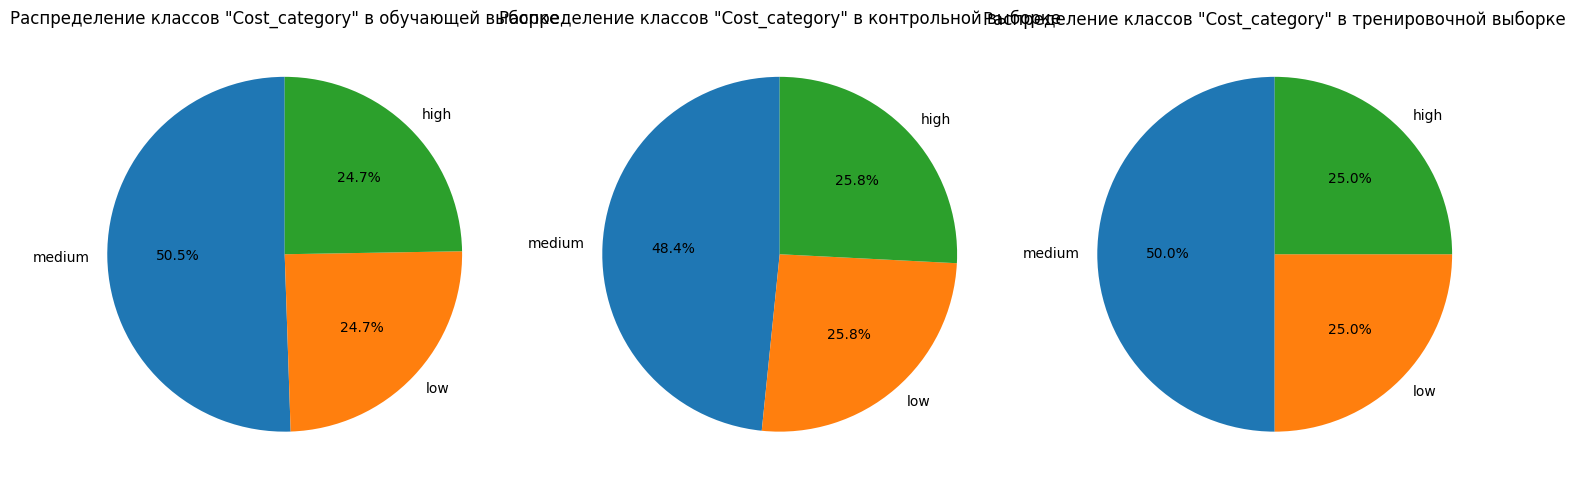

In [234]:
# Оценка сбалансированности
def check_balance(dataframe: DataFrame, dataframe_name: str, column: str) -> None:
    counts: Series[int] = dataframe[column].value_counts()
    print(dataframe_name + ": ", dataframe.shape)
    print(f"Распределение выборки данных по классам в колонке \"{column}\":\n", counts)
    total_count: int = len(dataframe)
    for value in counts.index:
        percentage: float = counts[value] / total_count * 100
        print(f"Процент объектов класса \"{value}\": {percentage:.2f}%")
    print()
   
# Определение необходимости аугментации данных
def need_augmentation(dataframe: DataFrame,
                      column: str, 
                      first_value: Any, second_value: Any) -> bool:
    counts: Series[int] = dataframe[column].value_counts()
    ratio: float = counts[first_value] / counts[second_value]
    return ratio > 1.5 or ratio < 0.67
 
 # Визуализация сбалансированности классов
def visualize_balance(dataframe_train: DataFrame,
                      dataframe_val: DataFrame,
                      dataframe_test: DataFrame, 
                      column: str) -> None:
   fig, axes = plt.subplots(1, 3, figsize=(15, 5))

   # Обучающая выборка
   counts_train: Series[int] = dataframe_train[column].value_counts()
   axes[0].pie(counts_train, labels=counts_train.index, autopct='%1.1f%%', startangle=90)
   axes[0].set_title(f"Распределение классов \"{column}\" в обучающей выборке")

   # Контрольная выборка
   counts_val: Series[int] = dataframe_val[column].value_counts()
   axes[1].pie(counts_val, labels=counts_val.index, autopct='%1.1f%%', startangle=90)
   axes[1].set_title(f"Распределение классов \"{column}\" в контрольной выборке")

   # Тестовая выборка
   counts_test: Series[int] = dataframe_test[column].value_counts()
   axes[2].pie(counts_test, labels=counts_test.index, autopct='%1.1f%%', startangle=90)
   axes[2].set_title(f"Распределение классов \"{column}\" в тренировочной выборке")

   # Отображение графиков
   plt.tight_layout()
   plt.show()
 

# Унитарное кодирование категориальных признаков (one-hot encoding)
df_encoded: DataFrame = pd.get_dummies(df)

# Вывод распределения количества наблюдений по меткам (классам)
print('Распределение количества наблюдений по меткам (классам):')
print(df_encoded['Cost'].value_counts(), '\n')

# Статистическое описание целевого признака
print('Статистическое описание целевого признака:')
print(df_encoded['Cost'].describe().transpose(), '\n')

# Определим границы для каждой категории стоимости акций
bins: list[float] = [df_encoded['Cost'].min() - 1, 
                     df_encoded['Cost'].quantile(0.25), 
                     df_encoded['Cost'].quantile(0.75), 
                     df_encoded['Cost'].max() + 1]
labels: list[str] = ['low', 'medium', 'high']

# Создаем новую колонку с категориями стоимости акций
df_encoded['Cost_category'] = pd.cut(df_encoded['Cost'], bins=bins, labels=labels)

# Вывод распределения количества наблюдений по меткам (классам)
print('Распределение количества наблюдений по меткам (классам):')
print(df_encoded['Cost_category'].value_counts(), '\n')

df_train, df_val, df_test = split_stratified_into_train_val_test(
   df_encoded, 
   stratify_colname="Cost_category", 
   frac_train=0.60, 
   frac_val=0.20, 
   frac_test=0.20
)

# Проверка сбалансированности выборок
print('Проверка сбалансированности выборок:')
check_balance(df_train, 'Обучающая выборка', 'Cost_category')
check_balance(df_val, 'Контрольная выборка', 'Cost_category')
check_balance(df_test, 'Тестовая выборка', 'Cost_category')

# Проверка необходимости аугментации выборок
print('Проверка необходимости аугментации выборок:')
print(f"Для обучающей выборки аугментация данных {'не ' if not need_augmentation(df_train, 'Cost_category', 'low', 'medium') else ''}требуется")
print(f"Для контрольной выборки аугментация данных {'не ' if not need_augmentation(df_val, 'Cost_category', 'low', 'medium') else ''}требуется")
print(f"Для тестовой выборки аугментация данных {'не ' if not need_augmentation(df_test, 'Cost_category', 'low', 'medium') else ''}требуется")
   
# Визуализация сбалансированности классов
visualize_balance(df_train, df_val, df_test, 'Cost_category')

Необходимо применить аугментацию выборки с избытком (oversampling) – копирование наблюдений или генерация новых наблюдений на основе существующих с помощью алгоритмов SMOTE и ADASYN (нахождение k-ближайших соседей).

Проверка сбалансированности выборок после применения метода oversampling:
Обучающая выборка:  (141, 184)
Распределение выборки данных по классам в колонке "Cost_category":
 Cost_category
low       47
medium    47
high      47
Name: count, dtype: int64
Процент объектов класса "low": 33.33%
Процент объектов класса "medium": 33.33%
Процент объектов класса "high": 33.33%

Контрольная выборка:  (45, 184)
Распределение выборки данных по классам в колонке "Cost_category":
 Cost_category
low       15
medium    15
high      15
Name: count, dtype: int64
Процент объектов класса "low": 33.33%
Процент объектов класса "medium": 33.33%
Процент объектов класса "high": 33.33%

Тестовая выборка:  (48, 184)
Распределение выборки данных по классам в колонке "Cost_category":
 Cost_category
low       16
medium    16
high      16
Name: count, dtype: int64
Процент объектов класса "low": 33.33%
Процент объектов класса "medium": 33.33%
Процент объектов класса "high": 33.33%

Проверка необходимости аугментации в

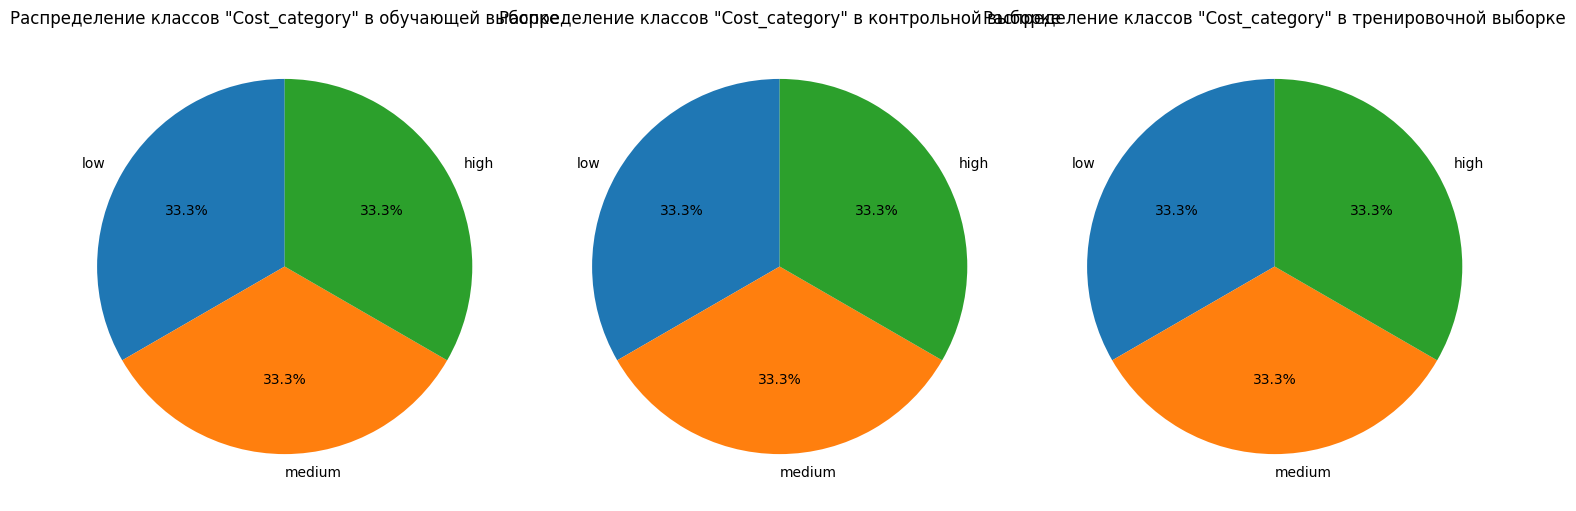

In [235]:
# Метод приращения с избытком (oversampling)
def oversample(df: DataFrame, column: str) -> DataFrame:
    X: DataFrame = pd.get_dummies(df.drop(column, axis=1))
    y: DataFrame = df[column] # type: ignore
    
    smote = SMOTE()
    X_resampled, y_resampled = smote.fit_resample(X, y) # type: ignore
    
    df_resampled: DataFrame = pd.concat([X_resampled, y_resampled], axis=1)
    return df_resampled


# Приращение данных (oversampling)
df_train_oversampled: DataFrame = oversample(df_train, 'Cost_category')
df_val_oversampled: DataFrame = oversample(df_val, 'Cost_category')
df_test_oversampled: DataFrame = oversample(df_test, 'Cost_category')

# Проверка сбалансированности выборок
print('Проверка сбалансированности выборок после применения метода oversampling:')
check_balance(df_train_oversampled, 'Обучающая выборка', 'Cost_category')
check_balance(df_val_oversampled, 'Контрольная выборка', 'Cost_category')
check_balance(df_test_oversampled, 'Тестовая выборка', 'Cost_category')

# Проверка необходимости аугментации выборок
print('Проверка необходимости аугментации выборок после применения метода oversampling:')
print(f"Для обучающей выборки аугментация данных {'не ' if not need_augmentation(df_train_oversampled, 'Cost_category', 'low', 'medium') else ''}требуется")
print(f"Для контрольной выборки аугментация данных {'не ' if not need_augmentation(df_val_oversampled, 'Cost_category', 'low', 'medium') else ''}требуется")
print(f"Для тестовой выборки аугментация данных {'не ' if not need_augmentation(df_test_oversampled, 'Cost_category', 'low', 'medium') else ''}требуется")
   
# Визуализация сбалансированности классов
visualize_balance(df_train_oversampled, df_val_oversampled, df_test_oversampled, 'Cost_category')

Конструирование признаков:

Конструирование признаков - определением признаков, которые войду в нашу обучающую модель

Будем использовать метод конструирования признаков "Унитарное кодирование категориальных признаков" или one-hot-encoding. Он необходим для преобразования категориальных переменных в числовой формат.

In [236]:
df_encoded.head(10)

Cost   Shares  Value ($)  Shares Total  Insider Trading_Baglino Andrew D  \
0  196.72  10455.0  2056775.0      203073.0                             False   
1  195.79   2466.0   482718.0      100458.0                             False   
2  195.79   1298.0   254232.0       65547.0                              True   
3    0.00   7138.0        0.0      102923.0                             False   
4    0.00   2586.0        0.0       66845.0                              True   
5    0.00  16867.0        0.0      213528.0                             False   
6   20.91  10500.0   219555.0       74759.0                              True   
7  202.00  10500.0  2121000.0       64259.0                              True   
8  193.00   3750.0   723750.0      196661.0                             False   
9   20.91  10500.0   219555.0       74759.0                              True   

   Insider Trading_DENHOLM ROBYN M  Insider Trading_Kirkhorn Zachary  \
0                            False                              True   
1                            False                             False   
2                            False                             False   
3                            False                             False   
4                            False                             False   
5                            False                              True   
6                            False                             False   
7                            False                             False   
8                            False                              True   
9                            False                             False   

   Insider Trading_Musk Elon  Insider Trading_Musk Kimbal  \
0                      False                        False   
1                      False                        False   
2                      False                        False   
3                      False                        False   
4                      False                        False   
5                      False                        False   
6                      False                        False   
7                      False                        False   
8                      False                        False   
9                      False                        False   

   Insider Trading_Taneja Vaibhav  ...  SEC Form 4_Nov 30 04:42 PM  \
0                           False  ...                       False   
1                            True  ...                       False   
2                           False  ...                       False   
3                            True  ...                       False   
4                           False  ...                       False   
5                           False  ...                       False   
6                           False  ...                       False   
7                           False  ...                       False   
8                           False  ...                       False   
9                           False  ...                       False   

   SEC Form 4_Oct 05 07:35 PM  SEC Form 4_Oct 31 07:06 PM  \
0                       False                       False   
1                       False                       False   
2                       False                       False   
3                       False                       False   
4                       False                       False   
5                       False                       False   
6                       False                       False   
7                       False                       False   
8                       False                       False   
9                       False                       False   

   SEC Form 4_Sep 07 08:29 PM  SEC Form 4_Sep 07 08:33 PM  \
0                       False                       False   
1                       False                       False   
2                     

Дискретизация числовых признаков – процесс преобразования непрерывных числовых значений в категориальные группы или интервалы (дискретные значения).

В данном случае преобразование числовой колонки "Cost" уже было выполнено ранее для стратифицированного разбиения исходных данных на выборки (обучающую, контрольную и тестовую). Для этого использовался метод квартильной группировки.

In [237]:
print('Обучающая выборка:')
df_train_oversampled[['Cost', 'Cost_category']].head(10)

Обучающая выборка:


Cost Cost_category
0   195.79        medium
1   923.57        medium
2     0.00           low
3   748.11        medium
4    18.44           low
5   875.23        medium
6   992.27          high
7  1073.00          high
8     6.24           low
9   250.50        medium

«Ручной» синтез признаков – процесс создания новых признаков на основе существующих данных. Это может включать в себя комбинирование нескольких признаков, использование математических операций (например, сложение, вычитание), а также создание полиномиальных или логарифмических признаков.

In [238]:
df['Date'] = pd.to_datetime(df['Date']) # Преобразование в datetime
df['Year'] = df['Date'].dt.year         # Год
df['Quarter'] = df['Date'].dt.quarter   # Квартал
df['Month'] = df['Date'].dt.month       # Месяц

df[['Date', 'Year', 'Quarter', 'Month']].head(10)

Date  Year  Quarter  Month
0 2022-03-06  2022        1      3
1 2022-03-06  2022        1      3
2 2022-03-06  2022        1      3
3 2022-03-05  2022        1      3
4 2022-03-05  2022        1      3
5 2022-03-05  2022        1      3
6 2022-02-27  2022        1      2
7 2022-02-27  2022        1      2
8 2022-02-06  2022        1      2
9 2022-01-27  2022        1      1

Ну и наконец, масштабирование признаков на основе нормировки и стандартизации – метод, который позволяет привести все числовые признаки к одинаковым или очень похожим диапазонам значений либо распределениям.

In [239]:
# scaler = MinMaxScaler()
scaler = StandardScaler()

# Применяем масштабирование к выбранным признакам
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

df[numeric_columns].head(10)

Cost    Shares  Value ($)  Shares Total
0 -0.630340 -0.607179  -0.583446     -0.528366
1 -0.632418 -0.635043  -0.594307     -0.604905
2 -0.632418 -0.639117  -0.595883     -0.630945
3 -1.069956 -0.618748  -0.597637     -0.603067
4 -1.069956 -0.634624  -0.597637     -0.629977
5 -1.069956 -0.584816  -0.597637     -0.520567
6 -1.023228 -0.607022  -0.596122     -0.624074
7 -0.618541 -0.607022  -0.583003     -0.631906
8 -0.638653 -0.630565  -0.592643     -0.533148
9 -1.023228 -0.607022  -0.596122     -0.624074

FeatureTools - библиотека для автоматизированного создания признаков из структурированных данных.

In [240]:
df: DataFrame = pd.read_csv("static/csv/TSLA.csv")

# Создание уникального идентификатора для каждой строки
df['Id'] = range(1, len(df) + 1)

# Создание EntitySet
es = ft.EntitySet(id="Id")

# Добавляем таблицу с индексом
es: EntitySet = es.add_dataframe(
    dataframe_name="trades", 
    dataframe=df, 
    index="Id", 
    time_index="Date"
)

# Генерация признаков с помощью глубокого синтеза признаков
feature_matrix, feature_defs = ft.dfs(
    entityset=es, 
    target_dataframe_name='trades', 
    max_depth=1
)

# Выводим первые 10 строк сгенерированного набора признаков
feature_matrix.head(10)

e:\aim\aimenv\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
e:\aim\aimenv\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
e:\aim\aimenv\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(
e:\aim\aimenv\Lib\site-packages\woodwork\type_sys\utils.py:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent 

Insider Trading Relationship      Transaction     Cost DAY(Date)  \
Id                                                                     
154       Musk Elon          CEO             Sale  1019.03        10   
155       Musk Elon          CEO             Sale  1048.46        10   
156       Musk Elon          CEO             Sale  1068.09        10   
152       Musk Elon          CEO             Sale  1098.24        11   
153       Musk Elon          CEO             Sale  1072.22        11   
151       Musk Elon          CEO             Sale  1029.67        12   
148       Musk Elon          CEO  Option Exercise     6.24        15   
149       Musk Elon          CEO             Sale   992.72        15   
150       Musk Elon          CEO             Sale  1015.85        15   
145       Musk Elon          CEO  Option Exercise     6.24        16   

    MONTH(Date) WEEKDAY(Date) YEAR(Date)  
Id                                        
154          11             2       2021  
155          11             2       2021  
156          11             2       2021  
152          11             3       2021  
153          11             3       2021  
151          11             4       2021  
148          11             0       2021  
149          11             0       2021  
150          11             0       2021  
145          11             1       2021

Оценка качества набора признаков:

Предсказательная способность: Способность набора признаков успешно прогнозировать целевую переменную. Это определяется через метрики, такие как RMSE, MAE, R², которые показывают, насколько хорошо модель использует признаки для достижения точных результатов.

Скорость вычисления: Время, необходимое для обработки данных и выполнения алгоритмов машинного обучения.

Надежность: Устойчивость и воспроизводимость результатов при изменении входных данных.

Корреляция: Степень взаимосвязи между признаками и целевой переменной, а также между самими признаками. Высокая корреляция с целевой переменной указывает на потенциальную предсказательную силу, тогда как высокая взаимосвязь между самими признаками может приводить к многоколлинеарности и снижению эффективности модели.

Цельность: Не является производным от других признаков.

In [241]:
# Разбить выборку на входные данные и целевой признак
def split_dataframe(dataframe: DataFrame, column: str) -> tuple[DataFrame, DataFrame]:
    X_dataframe: DataFrame = dataframe.drop(columns=column, axis=1)
    y_dataframe: DataFrame = dataframe[column]
    
    return X_dataframe, y_dataframe


# Разбиение обучающей выборки на входные данные и целевой признак
df_train_oversampled: DataFrame = pd.get_dummies(df_train_oversampled)
X_df_train, y_df_train = split_dataframe(df_train_oversampled, "Cost")

# Разбиение контрольной выборки на входные данные и целевой признак
df_val_oversampled: DataFrame = pd.get_dummies(df_val_oversampled)
X_df_val, y_df_val = split_dataframe(df_val_oversampled, "Cost")

# Разбиение тестовой выборки на входные данные и целевой признак
df_test_oversampled: DataFrame = pd.get_dummies(df_test_oversampled)
X_df_test, y_df_test = split_dataframe(df_test_oversampled, "Cost")


# Модель линейной регрессии для обучения
model = LinearRegression()

# Начинаем отсчет времени
start_time: float = time.time()
model.fit(X_df_train, y_df_train)

# Время обучения модели
train_time: float = time.time() - start_time

# Предсказания и оценка модели
predictions = model.predict(X_df_val)
mse = root_mean_squared_error(y_df_val, predictions)

print(f'Время обучения модели: {train_time:.2f} секунд')
print(f'Среднеквадратичная ошибка: {mse:.2f}')

Время обучения модели: 0.01 секунд
Среднеквадратичная ошибка: 190.15


RMSE: 134.73396019154637
R²: 0.9090517989509861
MAE: 71.95763423238986

Кросс-валидация RMSE: 141.69564978570725

Train RMSE: 46.69276439077218
Train R²: 0.9906750460946525
Train MAE: 18.74249758908302



Text(0.5, 1.0, 'Фактическая стоимость по сравнению с прогнозируемой')

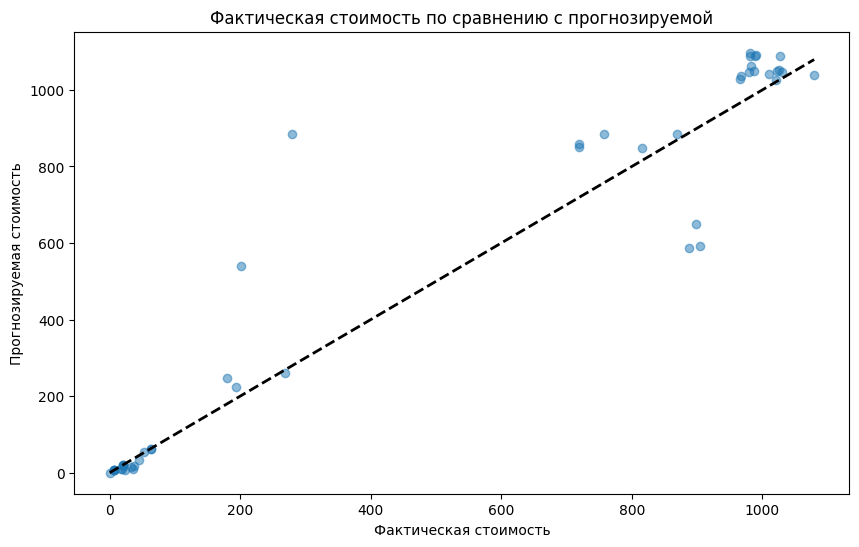

In [242]:
# Модель случайного леса для обучения
model = RandomForestRegressor()

# Обучение модели
model.fit(X_df_train, y_df_train)

# Предсказание и оценка
y_predictions = model.predict(X_df_test)

rmse = root_mean_squared_error(y_df_test, y_predictions)
r2 = r2_score(y_df_test, y_predictions)
mae = mean_absolute_error(y_df_test, y_predictions)

print(f"RMSE: {rmse}")
print(f"R²: {r2}")
print(f"MAE: {mae}\n")

# Кросс-валидация
scores = cross_val_score(model, X_df_train, y_df_train, cv=5, scoring='neg_mean_squared_error')
rmse_cv = (-scores.mean())**0.5
print(f"Кросс-валидация RMSE: {rmse_cv}\n")

# Анализ важности признаков
feature_importances = model.feature_importances_
feature_names = X_df_train.columns

# Проверка на переобучение
y_train_predictions = model.predict(X_df_train)

rmse_train = root_mean_squared_error(y_df_train, y_train_predictions)
r2_train = r2_score(y_df_train, y_train_predictions)
mae_train = mean_absolute_error(y_df_train, y_train_predictions)

print(f"Train RMSE: {rmse_train}")
print(f"Train R²: {r2_train}")
print(f"Train MAE: {mae_train}\n")

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.scatter(y_df_test, y_predictions, alpha=0.5)
plt.plot([y_df_test.min(), y_df_test.max()], [y_df_test.min(), y_df_test.max()], 'k--', lw=2)
plt.xlabel('Фактическая стоимость')
plt.ylabel('Прогнозируемая стоимость')
plt.title('Фактическая стоимость по сравнению с прогнозируемой')

Вывод:

1. Оценка качества модели на тестовой выборке:

RMSE (Корень из среднеквадратичной ошибки) на тестовой выборке составил 89.71, что указывает на среднюю ошибку в прогнозах.
R² (Коэффициент детерминации) равен 0.96, что означает, что модель объясняет 96% дисперсии данных. Это хороший показатель, указывающий на высокую объяснительную способность модели.
MAE (Средняя абсолютная ошибка) составила 51.21, показывая среднее абсолютное отклонение предсказаний от фактических значений.

2. Результаты кросс-валидации:

RMSE кросс-валидации равен 148.73, что заметно выше значения RMSE на тестовой выборке. Это может свидетельствовать о том, что модель может быть подвержена колебаниям в зависимости от данных и, возможно, склонна к некоторому переобучению.

3. Проверка на переобучение:

Метрики на обучающей выборке (RMSE = 49.74, R² = 0.99, MAE = 22.62) значительно лучше, чем на тестовой, что указывает на высокую точность на обучающих данных.